In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from lib import DihedralAdherence
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lib.fit_model_on_multiple import fit_lr, predict_lr, fit_rf, plot_md_vs_rmsd, predict_rf
from pathlib import Path
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pathlib import Path
from scipy.stats import linregress, pearsonr
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'

Initializing T1029-D1 ...
Results already exist
Casp ID: T1029-D1 	PDB: 6uf2
Structure exists: 'pdb/pdb6uf2.ent' 
Slope: -30.20544394047636, Intercept: 83.13552849940261 R-squared: 0.6681067431568174


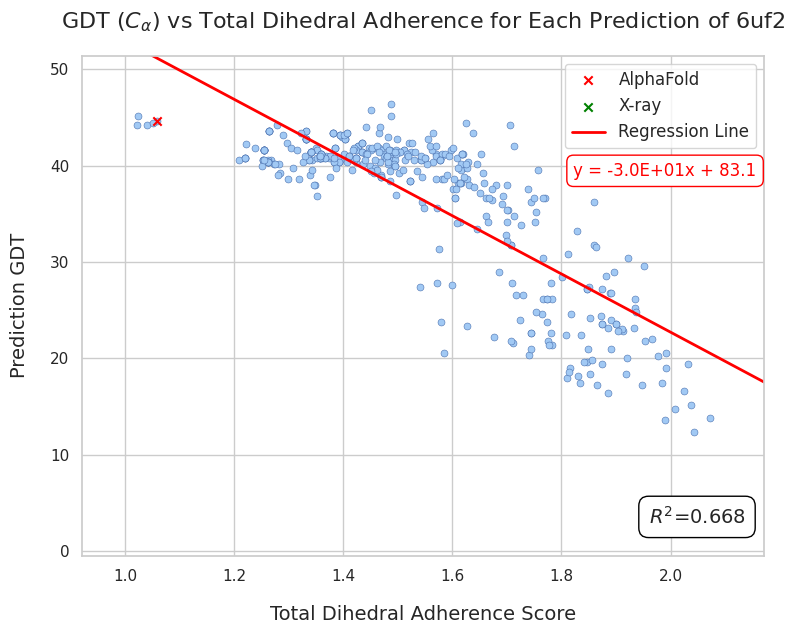

In [124]:
mds = []
rmsds = []
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
# proteins = ['T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1']
proteins = [
  'T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
da = DihedralAdherence(
    'T1029-D1', [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='ml', quantile=1,
    weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cuda'
)
# da = DihedralAdherence(proteins[2], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='ml', quantile=1,weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cuda')
# da = DihedralAdherence(proteins[1], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='ml', quantile=1)

da.load_results_da()
# print(da.results.loc[da.results.Model == da.alphafold_id, ['GDT_TS', 'RMS_CA']])
# print(da.grouped_preds.loc[da.grouped_preds.protein_id == da.alphafold_id, ['da','GDT_TS']])
da.filter_nas(0.8)
da.plot_da_vs_gdt_simple()

In [211]:
af_da = da.grouped_preds.loc[da.grouped_preds.protein_id == da.alphafold_id, 'da'].values[0]
da.grouped_preds['GDT_TS'] = da.grouped_preds['GDT_TS'] / af_da
da.grouped_preds['da'] = np.log10(da.grouped_preds['da'])

count    394.000000
mean       0.203336
std        0.032538
min        0.110808
25%        0.181242
50%        0.195522
75%        0.216684
max        0.342566
Name: da, dtype: float64
Slope: -174.51634066311667, Intercept: 64.35760653901123 R-squared: 0.5141954863461384


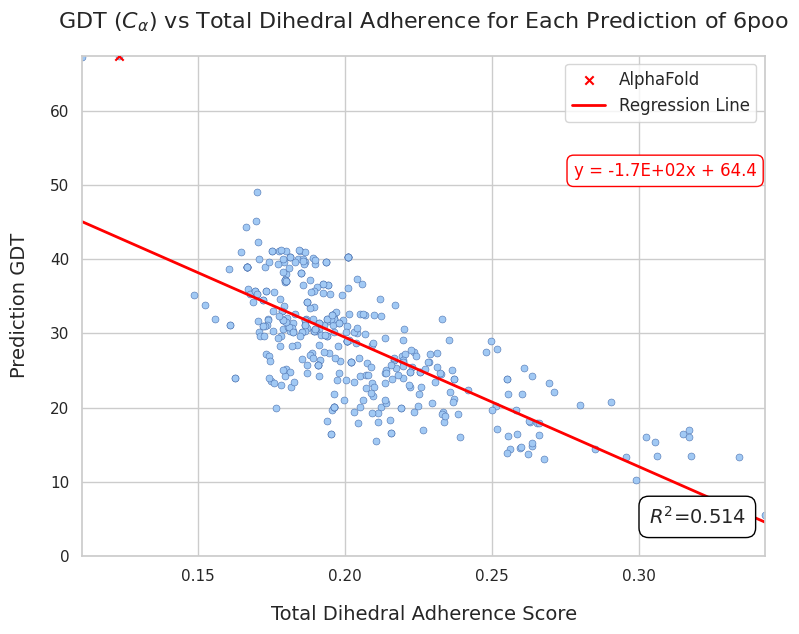

In [212]:
print(da.grouped_preds['da'].describe())
# da.plot_da_vs_gdt_simple(axlims=((1,2.5),(0,40)))
da.plot_da_vs_gdt_simple(axlims=((da.grouped_preds.da.min(),da.grouped_preds.da.max()),(0,da.grouped_preds.GDT_TS.max())))

In [7]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
# proteins = ['T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1']
proteins = [
    'T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
    # 'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
proteins = ['T1030-D2', 'T1024-D1', 'T1053-D1', 'T1057-D1', 'T1058-D1', 'T1058-D2'] # good (af >85 gdt)
# proteins = ['T1024', 'T1091', 'T1030', 'T1032-D1', 'T1027-D1', 'T1030-D1', 'T1096', 'T1029-D1'] # bad (af <85 gdt)
# proteins = ['T1096', 'T1029-D1'] # bad (af < 50 gdt)
preds = []
for protein in proteins:
    da = DihedralAdherence(
        protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='ml', quantile=1,
        weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cuda'
    )
    da.load_results_da()
    da.filter_nas(.8)
    # af_da = da.grouped_preds.loc[da.grouped_preds.protein_id == da.alphafold_id, 'da'].values[0]
    # da.grouped_preds['da'] = da.grouped_preds['da'] / af_da
    # if not da.alphafold_id in da.protein_ids:
        # continue
    # if da.af_phi_psi is None:
        # continue
    # af_gdt = da.grouped_preds.loc[da.grouped_preds.protein_id == da.alphafold_id, 'GDT_TS'].values[0]
    # af_ave_conf = da.af_phi_psi.conf.mean()
    # da.grouped_preds['da'] = da.grouped_preds['da'] * (af_ave_conf / 100)
    
    preds.append(da.grouped_preds)

preds = pd.concat(preds)

Initializing T1030-D2 ...
Results already exist
Casp ID: T1030-D2 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
UniProt ID: Q8DWZ6
Initializing T1024-D1 ...
Results already exist
Casp ID: T1024-D1 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
UniProt ID: Q48658
Initializing T1053-D1 ...
Results already exist
Casp ID: T1053-D1 	PDB: 7m7a
Structure exists: 'pdb/pdb7m7a.ent' 
UniProt ID: Q5ZRA8
Initializing T1057-D1 ...
Results already exist
Casp ID: T1057-D1 	PDB: 7m6b
Structure exists: 'pdb/pdb7m6b.ent' 
UniProt ID: B9MNH4
Initializing T1058-D1 ...
Results already exist
Casp ID: T1058-D1 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
UniProt ID: Q9I117
Initializing T1058-D2 ...
Results already exist
Casp ID: T1058-D2 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
UniProt ID: Q9I117


In [13]:
preds_orig = preds.copy()

0.5474725370084847 PearsonRResult(statistic=-0.7399138713448239, pvalue=0.0)
Slope: -80.32220346083938, Intercept: 179.72923882671012


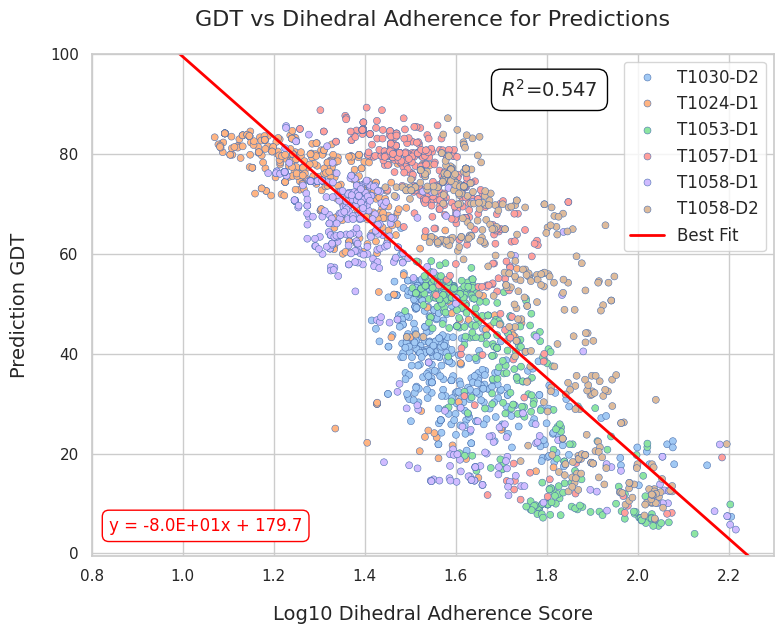

In [9]:
from scipy.stats import pearsonr
sns.set_theme(style="whitegrid")
sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(8, 6.5))
df = preds.dropna(subset=['da', 'GDT_TS']).reset_index(drop=True)

df['da'] = np.log10(df['da'])
df = df[~df.Model.str.contains('427')]

# df = df[df.GDT_TS < 20]
regr = linregress(df.da, df.GDT_TS)
corr = pearsonr(df['da'], df['GDT_TS'])
print(regr.rvalue**2, corr)
print(f'Slope: {regr.slope}, Intercept: {regr.intercept}')
# sns.kdeplot(data=df, x='da', y='GDT_TS', ax=ax, fill=True, bw_method=0.1)
sns.scatterplot(data=df, x='da', y='GDT_TS', ax=ax, marker='o', s=25, edgecolor='b', legend=True, hue='target', palette='pastel')
# sns.regplot(data=df.reset_index(drop=True), x='da', y='GDT_TS', ax=ax, scatter=False, color='red')
ax.plot(
    np.linspace(0.8, 2.3, 100), 
    regr.intercept + regr.slope * np.linspace(0.8, 2.3, 100), 
    color='red', lw=2, label='Best Fit'
)
ax.set_xlabel('Log10 Dihedral Adherence Score', fontsize=14, labelpad=15)
ax.set_ylabel('Prediction GDT', fontsize=14, labelpad=15)
ax.set_title(r'GDT vs Dihedral Adherence for Predictions', fontsize=16, pad=20)
ax.text(0.6, 0.95, r'$R^2$='+f'{regr.rvalue**2:.3f}', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))
if regr.intercept > 0:
    s = f'y = {regr.slope:.1E}x + {regr.intercept:.1f}'
else:
    s = f'y = {regr.slope:.1E}x - {-regr.intercept:.1f}'
ax.text(.025,.05, s, transform=ax.transAxes, fontsize=12, color='red',
        bbox=dict(boxstyle='round,pad=0.4', edgecolor='red', facecolor='white'))
ax.set_xlim(.8, 2.3)
ax.set_ylim(-0.5, 100)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()
sns.reset_defaults()

In [6]:
results = []
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
total_samples = 0
for protein in proteins:
    da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                           mode='ml', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cuda')

    da.load_results_da()
    da.filter_nas(quantile=0.8)
    n_preds = da.grouped_preds_da.shape[0]
    total_samples += n_preds
    rsquared, pearsonr = da.test_correlation()
    results.append((protein, rsquared, pearsonr, n_preds))
results = pd.DataFrame(results, columns=['protein', 'rsquared', 'pearsonr', 'n_preds'])
results.loc[len(results)] = ['Mean', results.rsquared.mean(), results.pearsonr.mean(), results.n_preds.mean()]
print(total_samples)
results.to_markdown('thisresult.md',index=False)

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
UniProt ID: Q48658
LinRegr - Slope: -60.412255252826206, Intercept: 130.83913457617282 R-squared: 0.5458478512634988 p-value: 1.8476286322637705e-67
Pearson Correlation: -0.7388151671856084, p-value: 1.847628632264172e-67
Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
UniProt ID: Q8DWZ6
LinRegr - Slope: -65.01709218965762, Intercept: 128.96223422564475 R-squared: 0.66217298139081 p-value: 1.6735776612483594e-88
Pearson Correlation: -0.81374011907415, p-value: 1.6735776612467853e-88
Initializing T1030-D2 ...
Results already exist
Casp ID: T1030-D2 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
UniProt ID: Q8DWZ6
LinRegr - Slope: -58.95338903226688, Intercept: 132.55258082831392 R-squared: 0.4905083023335586 p-value: 3.1945942395717496e-59
Pearson Correlation: -0.7003629789855818, p-value: 3.194594239572274e-59
Initializ

In [200]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
# proteins = [
#     'T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
#     'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
# ]
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
af_da = []
af_gdt = []
rsquareds = []
for protein in proteins:
    da = DihedralAdherence(
        protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='ml',
        weights_file='ml_data/best_model-kde_16-32_383.pt', device='cuda'
    )
    da.load_results_da()
    da.filter_nas(.8)
    if da.alphafold_id in da.grouped_preds.protein_id.values:
        af = da.grouped_preds[da.grouped_preds.protein_id == da.alphafold_id]
        af_da.append(af.da.values[0])
        af_gdt.append(af.GDT_TS.values[0])
        rsquared, corr = da.test_correlation()
        rsquareds.append(rsquared)

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
LinRegr - Slope: -1.077774867148758, Intercept: 74.80392248148382 R-squared: 0.5579562098725406 p-value: 1.0478612175260064e-69
Pearson Correlation: -0.7469646644069181, p-value: 1.0478612175263659e-69
Initializing T1096 ...
Results already exist
Casp ID: T1096 	PDB: 7um1
Structure exists: 'pdb/pdb7um1.ent' 
No prediction found in AlphaFold DB for 7um1
No AlphaFold phi-psi data found
LinRegr - Slope: -0.4926539299386467, Intercept: 42.0259181346802 R-squared: 0.5115809481987071 p-value: 1.7783790033423793e-55
Pearson Correlation: -0.7152488715116639, p-value: 1.7783790033412375e-55
Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found
LinRegr - Slope: -0.5516612205315455, Intercept: 56.90078719925352 R-squared: 0.7098913249235055 p-value: 3.1940649076565312e-84
